In [1]:
# jupyter 
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


# initialise
%matplotlib inline

import numpy as np
#import theano
import scipy.io
from keras.utils import np_utils
from matplotlib import pyplot as plt

#from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import MaxPooling2D

from keras.layers import Input, concatenate, Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import Input, merge, Conv2D, UpSampling2D
from keras.optimizers import Adam, sgd
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
#from keras import losses
from keras import backend as K
from keras.models import load_model

THEANO_FLAGS='floatX=float32, exception_verbosity=high'


# load data---------------------------------------------------------------
w,h = 28,28

# x_load_0 = scipy.io.loadmat('x__10000x28x28.mat')   #dict
# y_load_0 = scipy.io.loadmat('y__10000x28x28.mat')
# x_load = x_load_0['x_vals2']
# y_load = y_load_0['y_vals2']

# x_load_0 = scipy.io.loadmat('input8_from_10k.mat')   #dict
# y_load_0 = scipy.io.loadmat('det8_from_10k.mat')
# x_load_1 = x_load_0['input8']
# y_load_1 = y_load_0['det8']
    
x_load_0 = scipy.io.loadmat('input8ck.mat')   #dict
y_load_0 = scipy.io.loadmat('det8ck.mat')

x_load_1 = x_load_0['input8ck']
y_load_1 = y_load_0['det8ck']


    
x_load = np.expand_dims(x_load_1, 3)
y_load = np.expand_dims(y_load_1, 3)
print('y_load:', y_load.shape)
print('x_load:', x_load.shape)

#full dataset
x_train = x_load[:-2000] # first 8k out of 10k
y_train = y_load[:-2000]

x_test = x_load[-2000:] # last 2k
y_test = y_load[-2000:]
print('\n')
print('x_train:', x_train.shape)
print('x_test: ', x_test.shape)

#small dataset
x_train = x_load[:800] # first 800 out of 10k
y_train = y_load[:800]

x_test = x_load[800:1000] # next 200
y_test = y_load[800:1000]
print('\nsmaller dataset:\n')
print('x_train:', x_train.shape)
print('x_test: ', x_test.shape)

#corrected dataset
x_train = x_load[:540] # first 540 out of 677
y_train = y_load[:540]

x_test = x_load[540:] # next 137
y_test = y_load[540:]
print('\nsmaller dataset:\n')
print('x_train:', x_train.shape)
print('x_test: ', x_test.shape)

# adjust type
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_test_20 = x_test[0:20]



Using Theano backend.


('y_load:', (677L, 28L, 28L, 1L))
('x_load:', (677L, 28L, 28L, 1L))


('x_train:', (0L, 28L, 28L, 1L))
('x_test: ', (677L, 28L, 28L, 1L))

smaller dataset:

('x_train:', (677L, 28L, 28L, 1L))
('x_test: ', (0L, 28L, 28L, 1L))

smaller dataset:

('x_train:', (540L, 28L, 28L, 1L))
('x_test: ', (137L, 28L, 28L, 1L))


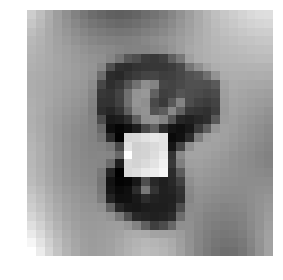

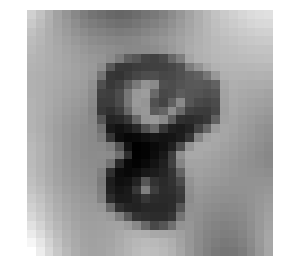

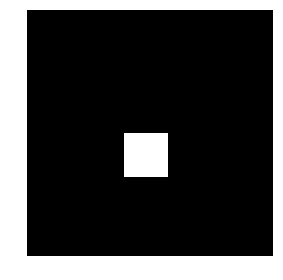

In [46]:
s = 543
alpha = 0.5
# overlay = x_load_1[s] * (1.0 - alpha) + y_load_1[s] * alpha
#overlay = x_load_1[s] * (1.7 - alpha) + y_load_1[s] * alpha
overlay = x_load_1[s] * (1.7 - alpha) + y_load_1[s] * alpha
#overlay = x_load_1[s] * (1.7 - alpha)
plt.imshow(overlay, cmap=plt.get_cmap('gray'))
# plt.imshow(y_load_1[0], cmap=plt.get_cmap('gray'))
#plt.imshow(y>thresh, cmap=plt.get_cmap('gray'))
#title = 'Prediction Thresholded'
plt.tight_layout()
plt.axis('off')
plt.show()

plt.imshow(x_load_1[s], cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.axis('off')
plt.show()

plt.imshow(y_load_1[s], cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.axis('off')
plt.show()

In [16]:
#loss
import theano.tensor as T
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def cal_weights_4loss(y_true):
    #size = y_true.shape[1] * y_true.shape[0] #tf syntax
    size = y_true.shape[1] * y_true.shape[2]  #theano syntax
    percentage_back = 0.0
    percentage_fore = 0.0
    percentage_back = np.count_nonzero(y_true == 0)/size*100
    percentage_fore = np.count_nonzero(y_true == 1)/size*100
    weight_back = np.reciprocal(percentage_back)
    weight_fore = np.reciprocal(percentage_fore)
    #print(percentage_back, percentage_fore)
    return percentage_back, percentage_fore


def weighted_crossentropy_coeff(y_true, y_pred):
#     y_true = T.transpose(y_true, (0,2,3,1))
#     y_pred = T.transpose(y_pred, (0,2,3,1))
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    weights = y_true * class_weights[0] 
    temp = T.eq(y_true, 0)
    temp = T.cast(temp, 'float32')
    temp = temp * class_weights[1]
    weights = weights + temp

    epsilon = 10e-8
    y_true = T.clip(y_true, epsilon, 1. - epsilon)
    #coeff = K.sum(((y_true * K.log(y_pred))*weights))
    coeff = K.sum(((y_true * K.log(1-y_pred))*weights))
    return coeff


def weighted_crossentropy_loss(y_true, y_pred):
    return -weighted_crossentropy_coeff(y_true, y_pred)


weight_back = np.zeros((y_test.shape[0]))
weight_fore = np.zeros((y_test.shape[0]))

# print(y_test.shape)
# print(weight_back.shape)

for i in np.arange(y_test.shape[0]):
    weight_back[i], weight_fore[i] = cal_weights_4loss(y_test[i])

loss_back = np.mean(weight_back)
loss_fore = np.mean(weight_fore)

ratio = loss_back/loss_fore
    
#class_weights = [1.5, 1.5/ratio]
class_weights = [0.8, 0.2]
print(loss_back, loss_fore, ratio, class_weights)


(2700.0, 0.0, inf, [0.8, 0.2])


In [4]:
w, h = 28, 28
inputs = Input((w, h, 1))
net_num = '1'
batch_num = 8
epoch_num = 15
thresh = 0.65
threshon = 0
sample = 0
#thresh = 0.5
loss_type  = 'weihgted'

def train_model0(net_num, get_unet0, batch_num, epoch_num, indcoef):

    checkpath = 'checkpoints/unet_' + net_num + '.best.h5'
    modelpath = 'models/unet_' + net_num + '.h5'
    weightpath = 'weights/unet_' + net_num + '.h5'

    model = get_unet0(Input((w,h,1)), indcoef)
    #print(type(model))
    #checkpoint = ModelCheckpoint(checkpath, monitor='val_loss', save_best_only=True)
    
    history = model.fit(x_train, y_train,
          batch_size=batch_num, epochs=epoch_num, 
          verbose=1, shuffle=True,
          validation_split=0.2, 
     #     callbacks=[checkpoint]
         )

    model.save(modelpath)
    model.save_weights(weightpath)
    
    #plot_history(history, indcoef)
    
    return model, history

def train_model(net_num, get_unet0, batch_num, epoch_num, indcoef):

#     checkpath = 'checkpoints/unet_' + net_num + '.best.h5'
#     modelpath = 'models/unet_' + net_num + '.h5'
#     weightpath = 'weights/unet_' + net_num + '.h5'

    model = get_unet0(Input((w,h,1)), indcoef)
    #print(type(model))
    #checkpoint = ModelCheckpoint(checkpath, monitor='val_loss', save_best_only=True)
    
    history = model.fit(x_train, y_train,
          batch_size=batch_num, epochs=epoch_num, 
          verbose=1, shuffle=True,
          validation_split=0.2, 
     #     callbacks=[checkpoint]
         )

#     model.save(modelpath)
#     model.save_weights(weightpath)
    
    #plot_history(history, indcoef)
    
    return model, history


def compiler_loss(indcoef):

    #if indcoef == 0:
    if indcoef == 'binary':
        #typecoeff = 'acc'
        typecoeff = 'binary_crossentropy'
        valcoeff = 'accuracy'
    
    #if indcoef == 1:
    if indcoef == 'dice':
        typecoeff = 'dice_coef'
        valcoeff = 'val_dice_coef'
        
    #if indcoef == 2:
    if indcoef == 'weighted':
        typecoeff = weighted_crossentropy_loss
        valcoeff = weighted_crossentropy_coeff
        
    return typecoeff, valcoeff

        
def plot_history(history, indcoef):
    
    #if indcoef == 0:
    if indcoef == 'binary':
        typecoeff = 'acc'
        valcoeff = 'val_acc'
    
    #if indcoef == 1:
    if indcoef == 'dice':
        typecoeff = 'dice_coef'
        valcoeff = 'val_dice_coef'
        
    #if indcoef == 2:
    if indcoef == 'weighted':
        typecoeff = 'weighted_crossentropy_coeff'
        valcoeff = 'val_weighted_crossentropy_coeff'
        
#     typecoeff = choose_loss(indcoef)[0]
#     valcoeff = choose_loss(indcoef)[1]
           
    # summarize history for accuracy
    plt.plot(history.history[typecoeff])
    plt.plot(history.history[valcoeff])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    
def predict(model, x_test):
    pred = model.predict(x_test, verbose=1)
    return pred
    
    
def plot_preds0(pred, x_test, sample, thresh, threshon):  
    test = x_test[sample,:,:,:].reshape(w,h)
    
    if threshon == 0:
        thresh = (np.max(test) - np.min(test))/2
    
    print('threshold:', thresh, 'usage:', threshon)
    print('min and max predicted values:',np.min(test), np.max(test))
    plt.imshow(test>thresh, cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

    plt.imshow(y_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Target')
    plt.axis('off')
    plt.show()

    plt.imshow(x_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Original')
    plt.axis('off')
    plt.show()
    
    
def plot_preds(pred, x_test, sample, thresh, threshon):  
    print(pred.shape)   # (20L, 28L, 28L, 1L)
    #test = #x_test[sample,:,:,:].reshape(w,h)
    test = pred[sample,:,:,:]
    print(test.shape)
    test2 = test.reshape(w,h)
    print(test2.shape)

#     if threshon == 0:
#         thresh = (np.max(test) - np.min(test))/2

    print('threshold:', thresh, 'usage:', threshon)
    print('min and max predicted values:',np.min(test), np.max(test))
    #plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
    if threshon == 0:
        plt.imshow(test2, cmap=plt.get_cmap('gray'))
        title = 'Prediction'
    if threshon == 1:
        plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
        title = 'Prediction Thresholded'
    plt.tight_layout()
    plt.title(title)
    plt.axis('off')
    plt.show()

    plt.imshow(y_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Target')
    plt.axis('off')
    plt.show()

    plt.imshow(x_test[sample,:,:,:].reshape(w,h), cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Original')
    plt.axis('off')
    plt.show()
    
def plot_preds_a(pred, x_test, sample, thresh, threshon):  
    print(pred.shape)   # (20L, 28L, 28L, 1L)
    #test = #x_test[sample,:,:,:].reshape(w,h)
    test = pred[sample,:,:,:]
    print(test.shape)
    test2 = test.reshape(w,h)
    print(test2.shape)

#     if threshon == 0:
#         thresh = (np.max(test) - np.min(test))/2

    print('threshold:', thresh, 'usage:', threshon)
    print('min and max predicted values:',np.min(test), np.max(test))
    #plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
    if threshon == 0:
        plt.imshow(test2, cmap=plt.get_cmap('gray'))
        title = 'Prediction'
    if threshon == 1:
        plt.imshow(test2>thresh, cmap=plt.get_cmap('gray'))
        title = 'Prediction Thresholded'
    plt.tight_layout()
    plt.title(title)
    plt.axis('off')
    plt.show()

    alpha1 = 0.2
    #overlay1 = test2 * (1 - alpha1) + y_test[sample,:,:,:].reshape(w,h) * alpha1
    overlay1 = test2 + y_test[sample,:,:,:].reshape(w,h) * alpha1
    #overlay1 = test2 * [1,0,0] + (y_test[sample,:,:,:].reshape(w,h) * alpha1 * [0,1,1])
    plt.imshow(overlay1, cmap=plt.get_cmap('gray'))
    #plt.imshow(overlay1)
    plt.tight_layout()
    plt.title('Prediction with Target ')
    plt.axis('off')
    plt.show()

    alpha2 = 0.5
    overlay2 = x_test[sample,:,:,:].reshape(w,h) * (1.7 - alpha2) + y_test[sample,:,:,:].reshape(w,h) * alpha2
    plt.imshow(overlay2, cmap=plt.get_cmap('gray'))
    plt.tight_layout()
    plt.title('Original with Target')
    plt.axis('off')
    plt.show()
    
def print_scores():
    num_test = (X_test.shape[0])
    test_score = np.zeros(num_test)

    for i in np.arange(num_test):
        mask = imgs_mask_test[i]
        test_score[i] = np.sum(y_test[i]-mask)
    mean_score = np.mean(test_score)
    print('test scores:', test_score)
    print('mean test score:', mean_score)



In [11]:
def get_unet2v1(inputs, lossind):

   
    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 4s - loss: 0.6923 - acc: 0.7283 - val_loss: 0.6908 - val_acc: 0.9639
Epoch 2/15
432/432 [==============================] - 4s - loss: 0.6888 - acc: 0.9671 - val_loss: 0.6851 - val_acc: 0.9681
Epoch 3/15
432/432 [==============================] - 4s - loss: 0.6705 - acc: 0.9650 - val_loss: 0.6447 - val_acc: 0.9672
Epoch 4/15
432/432 [==============================] - 5s - loss: 0.5682 - acc: 0.9680 - val_loss: 0.4384 - val_acc: 0.9681
Epoch 5/15
432/432 [==============================] - 5s - loss: 0.3150 - acc: 0.9681 - val_loss: 0.2669 - val_acc: 0.9681
Epoch 6/15
432/432 [==============================] - 5s - loss: 0.2613 - acc: 0.9681 - val_loss: 0.2535 - val_acc: 0.9681
Epoch 7/15
432/432 [==============================] - 5s - loss: 0.2471 - acc: 0.9681 - val_loss: 0.2384 - val_acc: 0.9681
Epoch 8/15
432/432 [==============================] - 5s - loss: 0.2311 - acc: 0.9681 - val_l

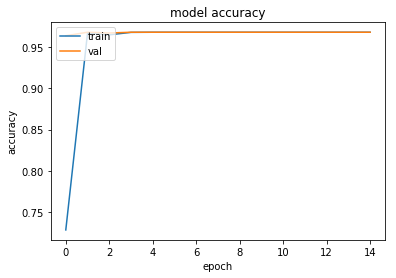

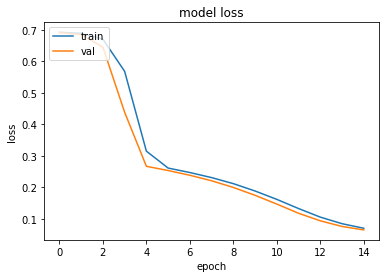

20/20 [==============================] - 0s


In [32]:
loss_type = 'binary'
model_2v1, history = train_model('2v2', get_unet2v1, 8, 15, loss_type)

plot_history(history, loss_type)

pred = predict(model_2v1, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 2.0476485e-07, 0.36634678)


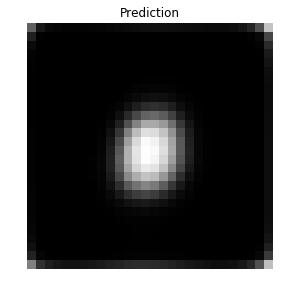

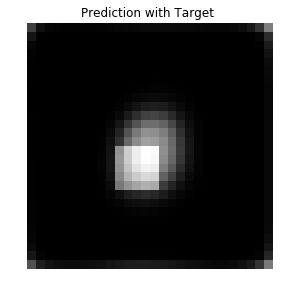

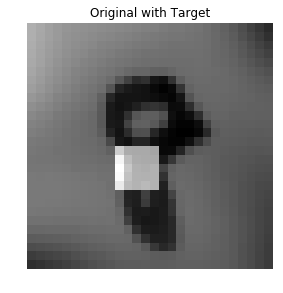

In [33]:
sample = 1;
plot_preds_a(pred, x_test_20, sample, thresh, 0)

Train on 432 samples, validate on 108 samples
Epoch 1/40
432/432 [==============================] - 4s - loss: 0.6809 - acc: 0.9661 - val_loss: 0.6752 - val_acc: 0.9679
Epoch 2/40
432/432 [==============================] - 4s - loss: 0.6665 - acc: 0.9681 - val_loss: 0.6550 - val_acc: 0.9681
Epoch 3/40
432/432 [==============================] - 4s - loss: 0.6217 - acc: 0.9677 - val_loss: 0.5588 - val_acc: 0.9668
Epoch 4/40
432/432 [==============================] - 4s - loss: 0.4099 - acc: 0.9668 - val_loss: 0.2760 - val_acc: 0.9668
Epoch 5/40
432/432 [==============================] - 4s - loss: 0.2588 - acc: 0.9668 - val_loss: 0.2443 - val_acc: 0.9668
Epoch 6/40
432/432 [==============================] - 4s - loss: 0.2318 - acc: 0.9668 - val_loss: 0.2181 - val_acc: 0.9668
Epoch 7/40
432/432 [==============================] - 4s - loss: 0.2075 - acc: 0.9668 - val_loss: 0.1945 - val_acc: 0.9668
Epoch 8/40
432/432 [==============================] - 4s - loss: 0.1843 - acc: 0.9668 - val_l

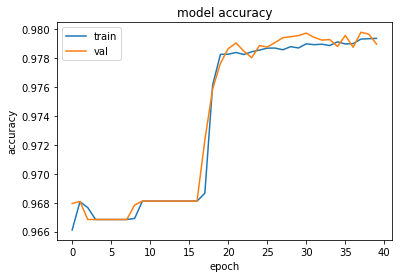

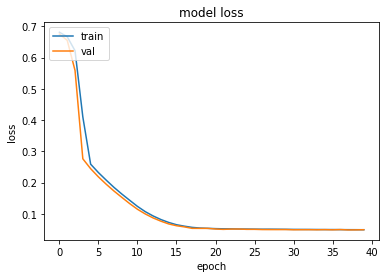

20/20 [==============================] - 0s


In [14]:
loss_type = 'binary'
model_2v1, history = train_model('2v1_2', get_unet2v1, 8, 40, loss_type)

plot_history(history, loss_type)

pred = predict(model_2v1, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 8.6091262e-07, 0.37769756)


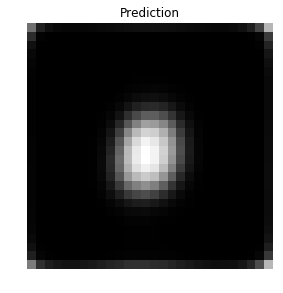

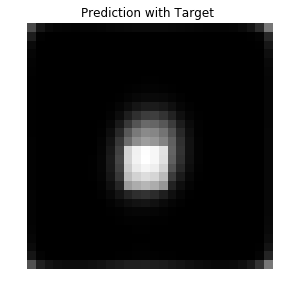

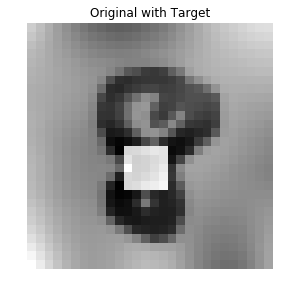

In [34]:
sample = 3;
plot_preds_a(pred, x_test_20, sample, thresh, 0)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 7s - loss: 111.1633 - weighted_crossentropy_coeff: -111.1633 - val_loss: 108.8261 - val_weighted_crossentropy_coeff: -108.8261
Epoch 2/15
432/432 [==============================] - 7s - loss: 110.6913 - weighted_crossentropy_coeff: -110.6913 - val_loss: 108.3277 - val_weighted_crossentropy_coeff: -108.3277
Epoch 3/15
432/432 [==============================] - 7s - loss: 109.2243 - weighted_crossentropy_coeff: -109.2243 - val_loss: 105.0813 - val_weighted_crossentropy_coeff: -105.0813
Epoch 4/15
432/432 [==============================] - 7s - loss: 98.0133 - weighted_crossentropy_coeff: -98.0133 - val_loss: 77.7998 - val_weighted_crossentropy_coeff: -77.7998
Epoch 5/15
432/432 [==============================] - 7s - loss: 37.2436 - weighted_crossentropy_coeff: -37.2436 - val_loss: 5.1707 - val_weighted_crossentropy_coeff: -5.1707
Epoch 6/15
432/432 [==============================] - 8s - 

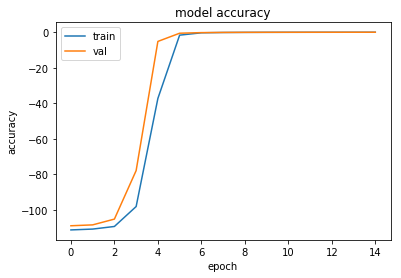

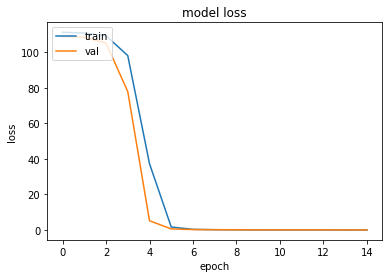

NameError: name 'model_2v1' is not defined

In [12]:
loss_type = 'weighted'
model_2v1w, history = train_model('2v2', get_unet2v1, 8, 15, loss_type)

plot_history(history, loss_type)



In [13]:
pred_2v1w = predict(model_2v1w, x_test_20)

20/20 [==============================] - 0s


(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.28452733, 0.99995983)


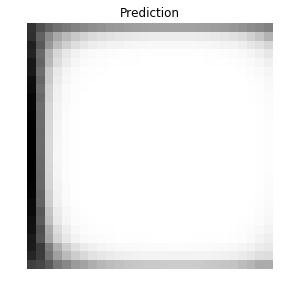

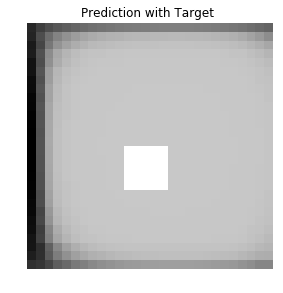

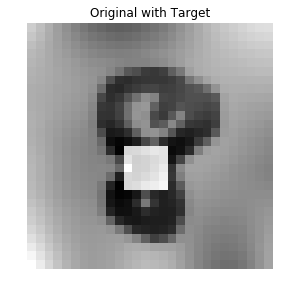

In [21]:
sample = 3
plot_preds_a(pred_2v1w, x_test_20, sample, thresh, 0)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 8s - loss: 109.2962 - weighted_crossentropy_coeff: -109.2962 - val_loss: 106.5741 - val_weighted_crossentropy_coeff: -106.5741
Epoch 2/15
432/432 [==============================] - 8s - loss: 107.0352 - weighted_crossentropy_coeff: -107.0352 - val_loss: 102.9017 - val_weighted_crossentropy_coeff: -102.9017
Epoch 3/15
432/432 [==============================] - 8s - loss: 97.4850 - weighted_crossentropy_coeff: -97.4850 - val_loss: 82.8080 - val_weighted_crossentropy_coeff: -82.8080
Epoch 4/15
432/432 [==============================] - 8s - loss: 52.9459 - weighted_crossentropy_coeff: -52.9459 - val_loss: 17.1189 - val_weighted_crossentropy_coeff: -17.1189
Epoch 5/15
432/432 [==============================] - 8s - loss: 5.2395 - weighted_crossentropy_coeff: -5.2395 - val_loss: 1.1648 - val_weighted_crossentropy_coeff: -1.1648
Epoch 6/15
432/432 [==============================] - 8s - loss: 

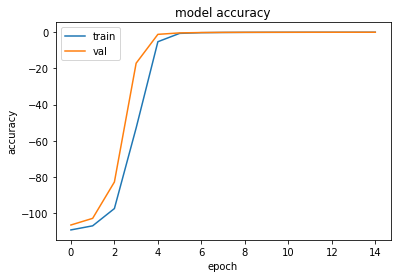

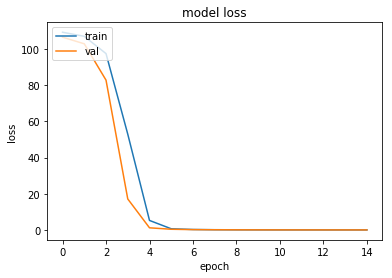

20/20 [==============================] - 0s


In [22]:
loss_type = 'weighted'
model_2v1w2, history = train_model('2v2', get_unet2v1, 8, 15, loss_type)

plot_history(history, loss_type)
pred_2v1w2 = predict(model_2v1w2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 1.4758871e-05, 0.47351018)


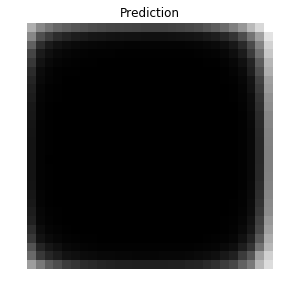

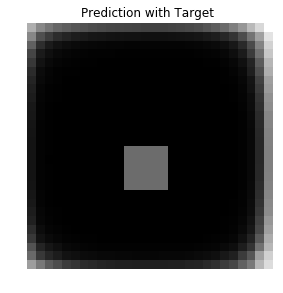

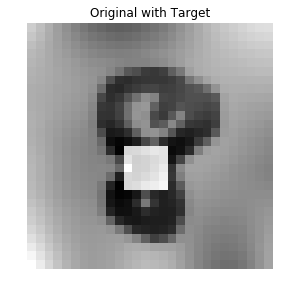

In [23]:
plot_preds_a(pred_2v1w2, x_test_20, sample, thresh, 0)

In [6]:
def get_unet2v2(inputs, lossind):

   
    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    conv6 = BatchNormalization(axis=-1)(conv6)
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv6)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 3s - loss: 0.6923 - acc: 0.5108 - val_loss: 0.5395 - val_acc: 0.9337
Epoch 2/15
432/432 [==============================] - 4s - loss: 0.6902 - acc: 0.6303 - val_loss: 0.5709 - val_acc: 0.9337
Epoch 3/15
432/432 [==============================] - 4s - loss: 0.6865 - acc: 0.6494 - val_loss: 0.5953 - val_acc: 0.9337
Epoch 4/15
432/432 [==============================] - 4s - loss: 0.6789 - acc: 0.6690 - val_loss: 0.6095 - val_acc: 0.9337
Epoch 5/15
432/432 [==============================] - 4s - loss: 0.6665 - acc: 0.6865 - val_loss: 0.6136 - val_acc: 0.9381
Epoch 6/15
432/432 [==============================] - 4s - loss: 0.6543 - acc: 0.7446 - val_loss: 0.6147 - val_acc: 0.9347
Epoch 7/15
432/432 [==============================] - 4s - loss: 0.6431 - acc: 0.7805 - val_loss: 0.6109 - val_acc: 0.9259
Epoch 8/15
432/432 [==============================] - 4s - loss: 0.6307 - acc: 0.8028 - val_l

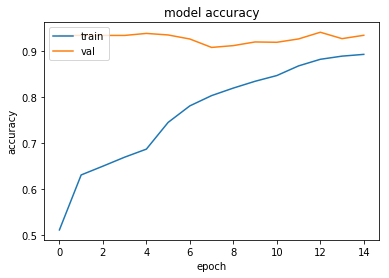

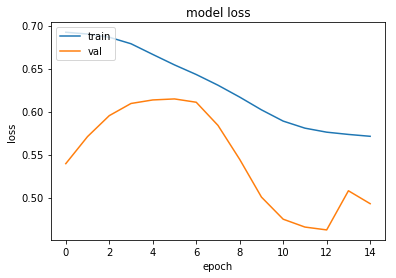

20/20 [==============================] - 0s


In [7]:
loss_type = 'binary'
model_2v2, history = train_model('2v2', get_unet2v2, 8, 15, loss_type)

plot_history(history, loss_type)

pred_2v2 = predict(model_2v2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.20258155, 0.98079604)


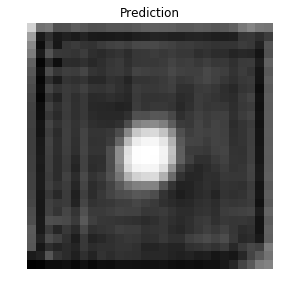

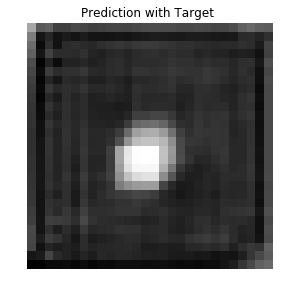

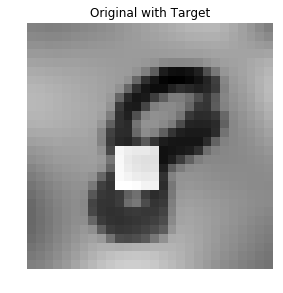

In [8]:
plot_preds_a(pred_2v2, x_test_20, sample, thresh, 0)

Train on 432 samples, validate on 108 samples
Epoch 1/30
432/432 [==============================] - 4s - loss: 0.6920 - acc: 0.5910 - val_loss: 0.7513 - val_acc: 0.0332
Epoch 2/30
432/432 [==============================] - 4s - loss: 0.6909 - acc: 0.6232 - val_loss: 0.7371 - val_acc: 0.0332
Epoch 3/30
432/432 [==============================] - 4s - loss: 0.6891 - acc: 0.6235 - val_loss: 0.7252 - val_acc: 0.0332
Epoch 4/30
432/432 [==============================] - 4s - loss: 0.6859 - acc: 0.6171 - val_loss: 0.7129 - val_acc: 0.0332
Epoch 5/30
432/432 [==============================] - 4s - loss: 0.6810 - acc: 0.6118 - val_loss: 0.6968 - val_acc: 0.4563
Epoch 6/30
432/432 [==============================] - 5s - loss: 0.6752 - acc: 0.6213 - val_loss: 0.6756 - val_acc: 0.7335
Epoch 7/30
432/432 [==============================] - 5s - loss: 0.6683 - acc: 0.6510 - val_loss: 0.6562 - val_acc: 0.8032
Epoch 8/30
432/432 [==============================] - 5s - loss: 0.6637 - acc: 0.6832 - val_l

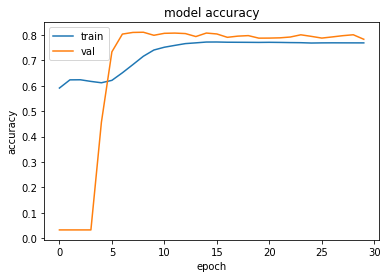

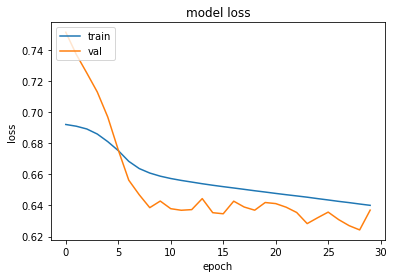

20/20 [==============================] - 0s


In [9]:
loss_type = 'binary'
model_2v2, history = train_model('2v2', get_unet2v2, 8, 30, loss_type)

plot_history(history, loss_type)

pred_2v2 = predict(model_2v2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.37480515, 0.94192624)


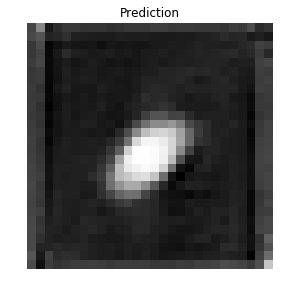

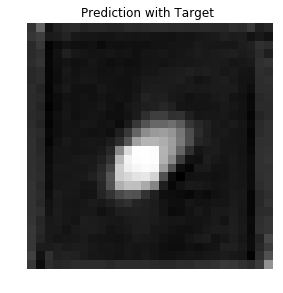

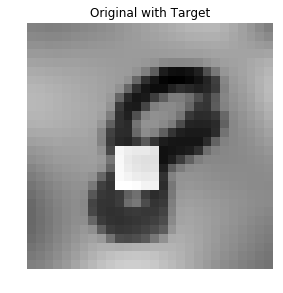

In [10]:
plot_preds_a(pred_2v2, x_test_20, sample, thresh, 0)

In [ ]:
loss_type = 'weighted'
model_2v2, history = train_model('2v2', get_unet2v2, 8, 15, loss_type)

plot_history(history, loss_type)

pred_2v2 = predict(model_2v2, x_test_20)

In [15]:
loss_type = 'binary'
model_2v1, history = train_model('2v1_2', get_unet2v1, 8, 40, loss_type)

plot_history(history, loss_type)

pred = predict(model_2v1, x_test_20)

Train on 432 samples, validate on 108 samples
Epoch 1/40
256/432 [================>.............] - ETA: 2s - loss: 0.6914 - acc: 0.7325

KeyboardInterrupt: 

In [13]:
def get_unet2v2(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 432 samples, validate on 108 samples
Epoch 1/35
432/432 [==============================] - 0s - loss: 0.6671 - acc: 0.9309 - val_loss: 0.6632 - val_acc: 0.9329
Epoch 2/35
432/432 [==============================] - 0s - loss: 0.6589 - acc: 0.9335 - val_loss: 0.6551 - val_acc: 0.9337
Epoch 3/35
432/432 [==============================] - 0s - loss: 0.6506 - acc: 0.9337 - val_loss: 0.6466 - val_acc: 0.9337
Epoch 4/35
432/432 [==============================] - 0s - loss: 0.6420 - acc: 0.9338 - val_loss: 0.6382 - val_acc: 0.9343
Epoch 5/35
432/432 [==============================] - 0s - loss: 0.6336 - acc: 0.9352 - val_loss: 0.6299 - val_acc: 0.9360
Epoch 6/35
432/432 [==============================] - 0s - loss: 0.6253 - acc: 0.9363 - val_loss: 0.6217 - val_acc: 0.9376
Epoch 7/35
432/432 [==============================] - 0s - loss: 0.6171 - acc: 0.9588 - val_loss: 0.6136 - val_acc: 0.9674
Epoch 8/35
432/432 [==============================] - 0s - loss: 0.6089 - acc: 0.9680 - val_l

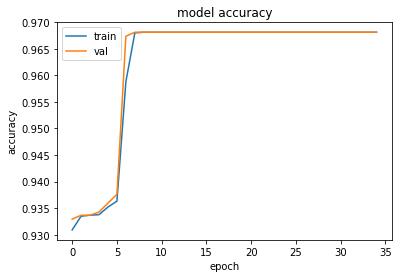

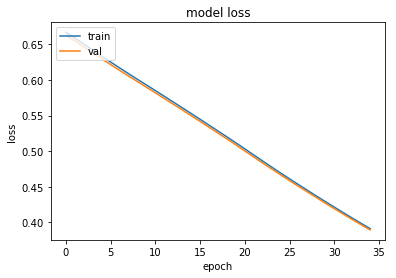

20/20 [==============================] - 0s


In [19]:
loss_type = 'binary'
model_2v2, history_2v2 = train_model('2v2', get_unet2v2, 8, 35, loss_type)

plot_history(history_2v2, loss_type)
pred2v2 = predict(model_2v2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.2489907, 0.42762622)


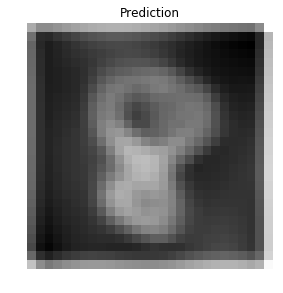

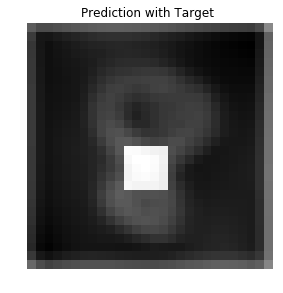

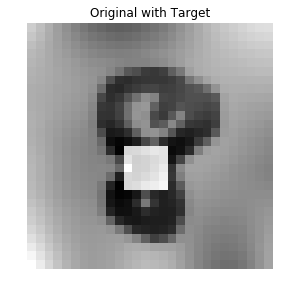

In [29]:
sample = 3;
plot_preds_a(pred2v2, x_test_20, sample, thresh, 0)

Train on 432 samples, validate on 108 samples
Epoch 1/35
432/432 [==============================] - 1s - loss: 0.6970 - acc: 0.2575 - val_loss: 0.6930 - val_acc: 0.3485
Epoch 2/35
432/432 [==============================] - 0s - loss: 0.6892 - acc: 0.6636 - val_loss: 0.6854 - val_acc: 0.8052
Epoch 3/35
432/432 [==============================] - 1s - loss: 0.6816 - acc: 0.8424 - val_loss: 0.6778 - val_acc: 0.8651
Epoch 4/35
432/432 [==============================] - 0s - loss: 0.6740 - acc: 0.8843 - val_loss: 0.6703 - val_acc: 0.8960
Epoch 5/35
432/432 [==============================] - 1s - loss: 0.6664 - acc: 0.8999 - val_loss: 0.6628 - val_acc: 0.9028
Epoch 6/35
432/432 [==============================] - 1s - loss: 0.6588 - acc: 0.9049 - val_loss: 0.6551 - val_acc: 0.9110
Epoch 7/35
432/432 [==============================] - 0s - loss: 0.6509 - acc: 0.9380 - val_loss: 0.6469 - val_acc: 0.9671
Epoch 8/35
432/432 [==============================] - 0s - loss: 0.6421 - acc: 0.9680 - val_l

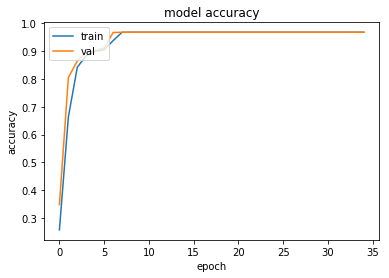

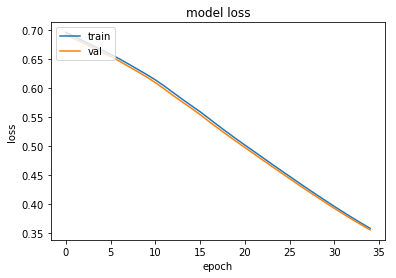

20/20 [==============================] - 0s


In [46]:
loss_type = 'binary'
model_2v2, history_2v2 = train_model('2v2', get_unet2v2, 8, 35, loss_type)

plot_history(history_2v2, loss_type)
pred2v2 = predict(model_2v2, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.21935701, 0.41759276)


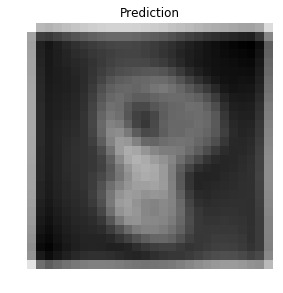

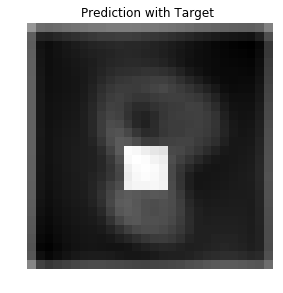

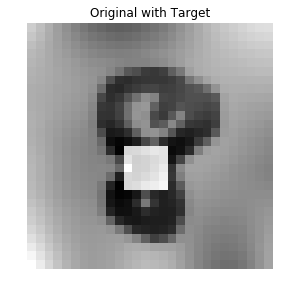

In [47]:
sample = 3;
plot_preds_a(pred2v2, x_test_20, sample, thresh, 0)

In [42]:
def get_unet2v3(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    #conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv2)
    
    model = Model(inputs=[inputs], outputs=[conv4])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


In [43]:
loss_type = 'binary'
model_2v3, history = train_model('2v3', get_unet2v3, 8, 15, loss_type)

pred = predict(model_2v3, x_test_20)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 3s - loss: 0.6015 - acc: 0.9681 - val_loss: 0.5929 - val_acc: 0.9681
Epoch 2/15
432/432 [==============================] - 3s - loss: 0.5823 - acc: 0.9681 - val_loss: 0.5729 - val_acc: 0.9681
Epoch 3/15
432/432 [==============================] - 3s - loss: 0.5613 - acc: 0.9681 - val_loss: 0.5512 - val_acc: 0.9681
Epoch 4/15
432/432 [==============================] - 3s - loss: 0.5386 - acc: 0.9681 - val_loss: 0.5277 - val_acc: 0.9681
Epoch 5/15
432/432 [==============================] - 3s - loss: 0.5126 - acc: 0.9681 - val_loss: 0.4989 - val_acc: 0.9681
Epoch 6/15
432/432 [==============================] - 3s - loss: 0.4828 - acc: 0.9681 - val_loss: 0.4689 - val_acc: 0.9681
Epoch 7/15
432/432 [==============================] - 3s - loss: 0.4524 - acc: 0.9681 - val_loss: 0.4384 - val_acc: 0.9681
Epoch 8/15
432/432 [==============================] - 3s - loss: 0.4216 - acc: 0.9681 - val_l

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.095079005, 0.38806999)


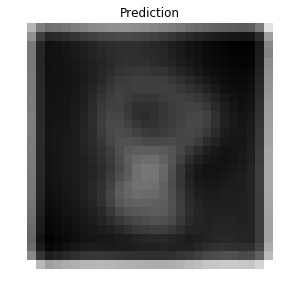

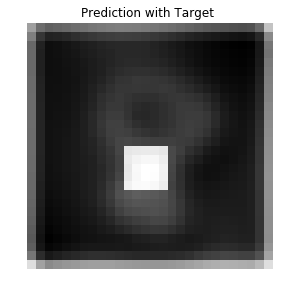

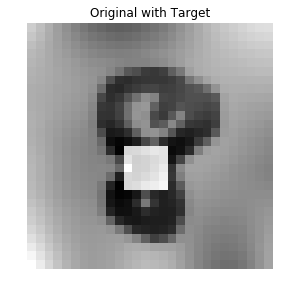

In [45]:
sample = 3
plot_preds_a(pred, x_test_20, sample, thresh, 0)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.010935068, 0.33033565)


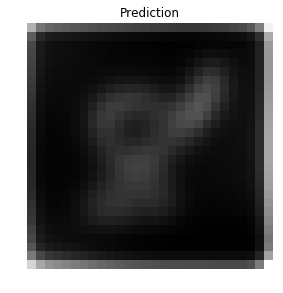

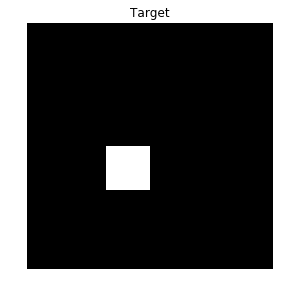

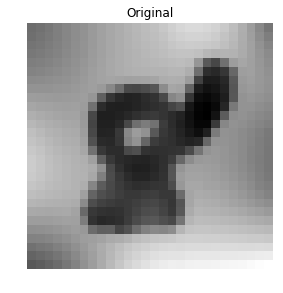

In [109]:
sample = 6
plot_preds(pred, x_test_20, sample, thresh, 0)

In [63]:
def get_unet2vv4(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
#     conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
#     conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
#     conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

In [52]:
loss_type = 'binary'
model_2vv4, history = train_model('2vv4', get_unet2vv4, 8, 15, loss_type)

pred = predict(model_2vv4, x_test_20)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 4s - loss: 0.6896 - acc: 0.6997 - val_loss: 0.6838 - val_acc: 0.9400
Epoch 2/15
432/432 [==============================] - 4s - loss: 0.6791 - acc: 0.9600 - val_loss: 0.6743 - val_acc: 0.9657
Epoch 3/15
432/432 [==============================] - 4s - loss: 0.6688 - acc: 0.9675 - val_loss: 0.6616 - val_acc: 0.9681
Epoch 4/15
432/432 [==============================] - 4s - loss: 0.6445 - acc: 0.9681 - val_loss: 0.6191 - val_acc: 0.9681
Epoch 5/15
432/432 [==============================] - 4s - loss: 0.5819 - acc: 0.9681 - val_loss: 0.5380 - val_acc: 0.9681
Epoch 6/15
432/432 [==============================] - 4s - loss: 0.4778 - acc: 0.9681 - val_loss: 0.4122 - val_acc: 0.9681
Epoch 7/15
432/432 [==============================] - 4s - loss: 0.3518 - acc: 0.9681 - val_loss: 0.2983 - val_acc: 0.9681
Epoch 8/15
432/432 [==============================] - 4s - loss: 0.2638 - acc: 0.9681 - val_l

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.015834553, 0.43371868)


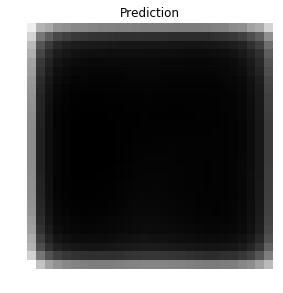

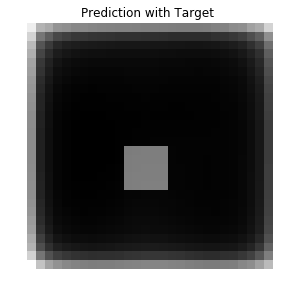

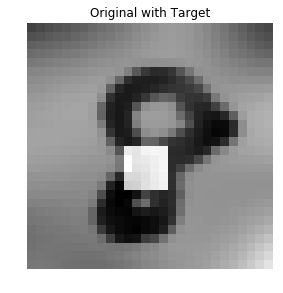

In [61]:
sample = 4
plot_preds_a(pred, x_test_20, sample, thresh, 0)

In [4]:
def get_unet2vv5(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
#     conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

In [5]:
loss_type = 'binary'
model_2vv5, history = train_model('2vv5', get_unet2vv5, 8, 15, loss_type)

pred_2vv5 = predict(model_2vv5, x_test_20)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 2s - loss: 0.6698 - acc: 0.9662 - val_loss: 0.6636 - val_acc: 0.9680
Epoch 2/15
432/432 [==============================] - 3s - loss: 0.6544 - acc: 0.9681 - val_loss: 0.6424 - val_acc: 0.9681
Epoch 3/15
432/432 [==============================] - 3s - loss: 0.6207 - acc: 0.9681 - val_loss: 0.5901 - val_acc: 0.9681
Epoch 4/15
432/432 [==============================] - 3s - loss: 0.5248 - acc: 0.9681 - val_loss: 0.4355 - val_acc: 0.9681
Epoch 5/15
432/432 [==============================] - 2s - loss: 0.3376 - acc: 0.9674 - val_loss: 0.2667 - val_acc: 0.9668
Epoch 6/15
432/432 [==============================] - 2s - loss: 0.2533 - acc: 0.9668 - val_loss: 0.2454 - val_acc: 0.9668
Epoch 7/15
432/432 [==============================] - 3s - loss: 0.2425 - acc: 0.9668 - val_loss: 0.2364 - val_acc: 0.9668
Epoch 8/15
432/432 [==============================] - 2s - loss: 0.2330 - acc: 0.9668 - val_l

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.0015170347, 0.45175225)


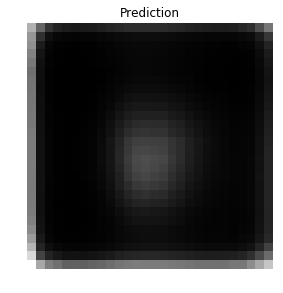

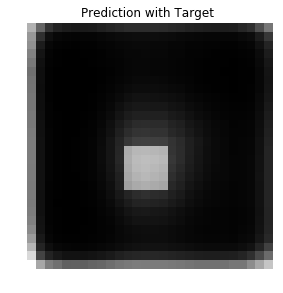

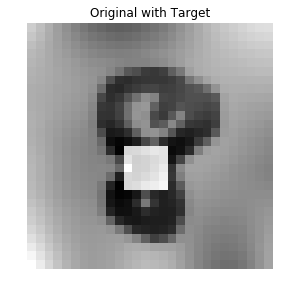

In [6]:
sample = 3
plot_preds_a(pred_2vv5, x_test_20, sample, thresh, 0)

In [7]:
def get_unet2vv6(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
#     conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    conv6 = BatchNormalization(axis=-1)(conv6)
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv6)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

In [8]:
loss_type = 'binary'
model_2vv6, history = train_model('2vv5', get_unet2vv6, 8, 15, loss_type)

pred_2vv6 = predict(model_2vv6, x_test_20)

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 3s - loss: 0.6937 - acc: 0.5627 - val_loss: 0.7871 - val_acc: 0.1008
Epoch 2/15
432/432 [==============================] - 3s - loss: 0.6847 - acc: 0.5915 - val_loss: 0.7631 - val_acc: 0.1008
Epoch 3/15
432/432 [==============================] - 3s - loss: 0.6759 - acc: 0.6319 - val_loss: 0.7437 - val_acc: 0.1008
Epoch 4/15
432/432 [==============================] - 3s - loss: 0.6679 - acc: 0.6458 - val_loss: 0.7273 - val_acc: 0.1010
Epoch 5/15
432/432 [==============================] - 3s - loss: 0.6571 - acc: 0.6680 - val_loss: 0.7082 - val_acc: 0.2331
Epoch 6/15
432/432 [==============================] - 3s - loss: 0.6432 - acc: 0.6975 - val_loss: 0.6858 - val_acc: 0.6657
Epoch 7/15
432/432 [==============================] - 3s - loss: 0.6291 - acc: 0.7352 - val_loss: 0.6592 - val_acc: 0.7860
Epoch 8/15
432/432 [==============================] - 3s - loss: 0.6158 - acc: 0.7752 - val_l

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.0015170347, 0.45175225)


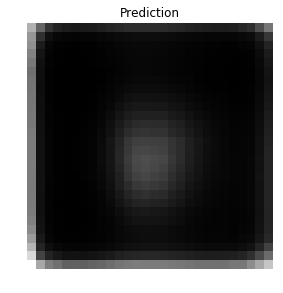

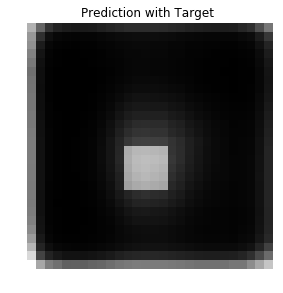

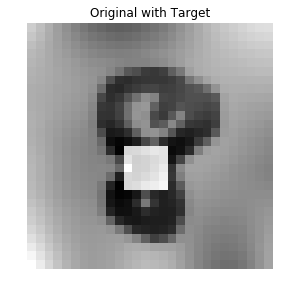

In [9]:
plot_preds_a(pred_2vv5, x_test_20, sample, thresh, 0)

In [39]:
def get_unet1v3(inputs, lossind):

    inputs = Input((w, h, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    up1 = concatenate([UpSampling2D(size=(2, 2))(pool1), conv1], axis=-1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    conv3 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv1)
    
    model = Model(inputs=[inputs], outputs=[conv3])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model


Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 1s - loss: 0.6079 - acc: 0.9663 - val_loss: 0.6044 - val_acc: 0.9667
Epoch 2/15
432/432 [==============================] - 0s - loss: 0.5995 - acc: 0.9668 - val_loss: 0.5961 - val_acc: 0.9668
Epoch 3/15
432/432 [==============================] - 0s - loss: 0.5911 - acc: 0.9669 - val_loss: 0.5877 - val_acc: 0.9670
Epoch 4/15
432/432 [==============================] - 0s - loss: 0.5824 - acc: 0.9674 - val_loss: 0.5790 - val_acc: 0.9678
Epoch 5/15
432/432 [==============================] - 1s - loss: 0.5738 - acc: 0.9681 - val_loss: 0.5705 - val_acc: 0.9681
Epoch 6/15
432/432 [==============================] - 0s - loss: 0.5653 - acc: 0.9681 - val_loss: 0.5621 - val_acc: 0.9681
Epoch 7/15
432/432 [==============================] - 1s - loss: 0.5569 - acc: 0.9681 - val_loss: 0.5539 - val_acc: 0.9681
Epoch 8/15
432/432 [==============================] - 0s - loss: 0.5487 - acc: 0.9681 - val_l

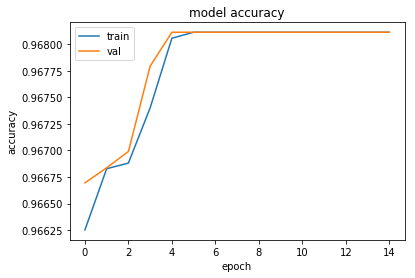

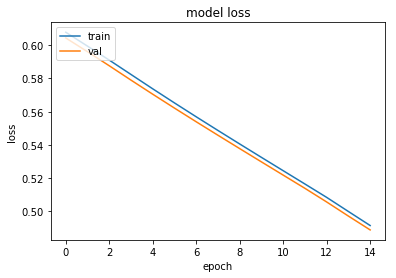

20/20 [==============================] - 0s


In [40]:
loss_type = 'binary'
model_1v3, history_1v3 = train_model('1v3', get_unet1v3, 8, 15, loss_type)

plot_history(history_1v3, loss_type)
pred_1v3 = predict(model_1v3, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 0.33290818, 0.47457752)


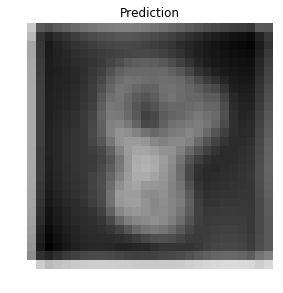

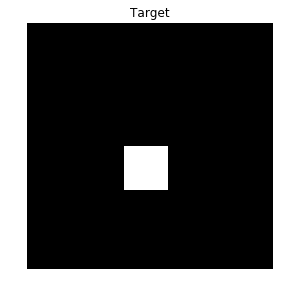

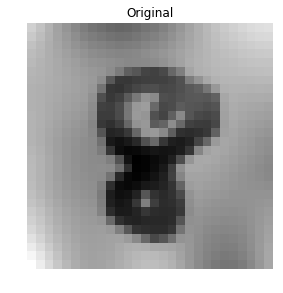

In [41]:
sample = 3
plot_preds(pred_1v3, x_test_20, sample, thresh, 0)

In [35]:
def get_unet2v1_2(inputs, lossind):

   
    inputs = Input((w, h, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)
    
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
   
    conv6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='conv6')(conv5)
    
    model = Model(inputs=[inputs], outputs=[conv6])

   # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=1e-5), loss=compiler_loss(lossind)[0], metrics=[compiler_loss(lossind)[1]])#/, sample_weight_mode="temporal")
    
    return model

Train on 432 samples, validate on 108 samples
Epoch 1/15
432/432 [==============================] - 10s - loss: 0.6858 - acc: 0.9661 - val_loss: 0.6823 - val_acc: 0.9670
Epoch 2/15
432/432 [==============================] - 10s - loss: 0.6745 - acc: 0.9678 - val_loss: 0.6604 - val_acc: 0.9681
Epoch 3/15
432/432 [==============================] - 10s - loss: 0.5946 - acc: 0.9681 - val_loss: 0.4475 - val_acc: 0.9681
Epoch 4/15
432/432 [==============================] - 10s - loss: 0.3250 - acc: 0.9681 - val_loss: 0.2878 - val_acc: 0.9681
Epoch 5/15
432/432 [==============================] - 10s - loss: 0.2775 - acc: 0.9681 - val_loss: 0.2666 - val_acc: 0.9681
Epoch 6/15
432/432 [==============================] - 10s - loss: 0.2576 - acc: 0.9681 - val_loss: 0.2469 - val_acc: 0.9681
Epoch 7/15
432/432 [==============================] - 10s - loss: 0.2360 - acc: 0.9681 - val_loss: 0.2218 - val_acc: 0.9681
Epoch 8/15
432/432 [==============================] - 10s - loss: 0.2073 - acc: 0.9681

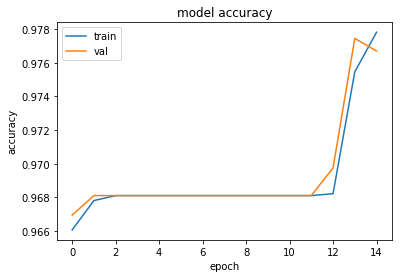

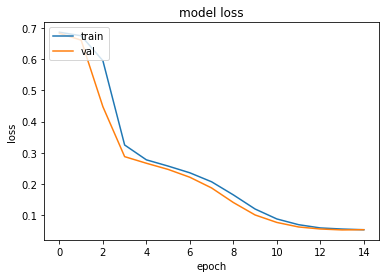

20/20 [==============================] - 0s


In [37]:
loss_type = 'binary'
model_2v1_2, history = train_model('2v1_2', get_unet2v1_2, 8, 15, loss_type)

plot_history(history, loss_type)

pred_2v1_2 = predict(model_2v1, x_test_20)

(20L, 28L, 28L, 1L)
(28L, 28L, 1L)
(28L, 28L)
('threshold:', 0.65, 'usage:', 0)
('min and max predicted values:', 8.6091262e-07, 0.37769756)


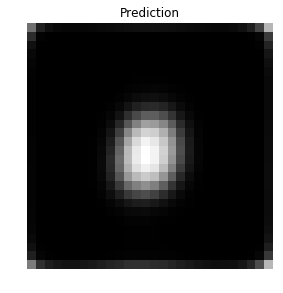

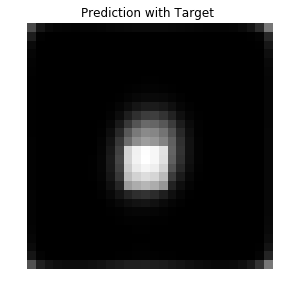

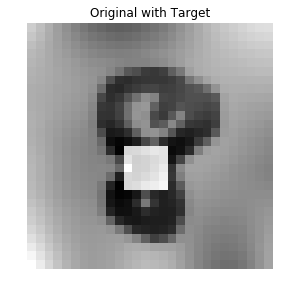

In [38]:
sample = 3;
plot_preds_a(pred_2v1_2, x_test_20, sample, thresh, 0)